# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [268]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math

In [269]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 1000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [270]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [271]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.random.normal([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(in_features=784, out_features=128)
        self.layer_2 = DenseLayer(in_features=128, out_features=256)
        self.output_layer = DenseLayer(in_features=256, out_features=10) 

    def __call__(self, x):
        first_layer = self.layer_1(x)
        second_layer = self.layer_2(first_layer)
        return self.output_layer(second_layer, 1)

In [272]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    y_true_np = y_true.numpy() if isinstance(y_true, tf.Tensor) else y_true

    cm = confusion_matrix(y_true_np, y_pred_classes)
    
    correct_predictions = np.trace(cm)  # Сума значень на головній діагоналі
    total_predictions = np.sum(cm)      # Загальна кількість передбачень
    accuracy = correct_predictions / total_predictions
    
    return accuracy * 100

In [273]:
model = NN(name="mnist")
opt = tf.optimizers.SGD(learning_rate=learning_rate)

def train(model_, X_, y_):
  with tf.GradientTape() as tape:
    pred = model_(X_)
    loss_ = cross_entropy(pred, y_)

    grads = tape.gradient(loss_, model_.trainable_variables)
    opt.apply_gradients(zip(grads, model_.trainable_variables))
  
  return loss_


In [274]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(model, batch_x, batch_y)

    if step % display_step == 0:
        pred = model(batch_x)
        loss_history.append(cross_entropy(pred, batch_y))
        accuracy_history.append(accuracy(pred, batch_y))


In [275]:
loss_history

[<tf.Tensor: shape=(), dtype=float32, numpy=299.4438>,
 <tf.Tensor: shape=(), dtype=float32, numpy=227.53827>,
 <tf.Tensor: shape=(), dtype=float32, numpy=174.83539>,
 <tf.Tensor: shape=(), dtype=float32, numpy=150.07663>,
 <tf.Tensor: shape=(), dtype=float32, numpy=120.07449>,
 <tf.Tensor: shape=(), dtype=float32, numpy=120.03347>,
 <tf.Tensor: shape=(), dtype=float32, numpy=138.42435>,
 <tf.Tensor: shape=(), dtype=float32, numpy=151.16414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=110.85858>,
 <tf.Tensor: shape=(), dtype=float32, numpy=86.357956>]

In [276]:
accuracy_history

[66.40625,
 76.5625,
 80.46875,
 80.078125,
 85.546875,
 87.5,
 86.328125,
 84.375,
 86.71875,
 89.453125]

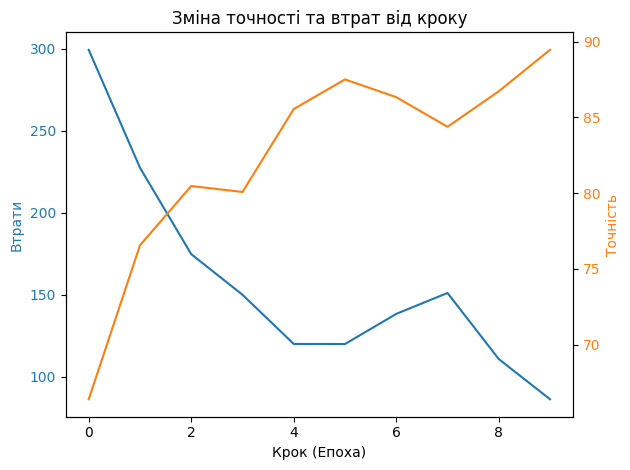

In [277]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Крок (Епоха)')
ax1.set_ylabel('Втрати', color=color)
ax1.plot(loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Точність', color=color)
ax2.plot(accuracy_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Зміна точності та втрат від кроку')

fig.tight_layout()
plt.show()


In [278]:
accuracy_value = accuracy(pred_y, y_test)
print(f'Точність моделі на тестових даних MNIST: {accuracy_value:.2f}%')

Точність моделі на тестових даних MNIST: 85.97%


In [279]:
pred_y = model(x_test)

In [280]:
accuracy(pred_y, y_test)

86.61